In [76]:
import sys

import numpy as np
np.set_printoptions(linewidth=150)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import EllipseCollection

from scipy.optimize import curve_fit

from lattviz import draw_lattice_2d

In [77]:
def draw_lattice_2d_local(lattice, cxs, cys, filename=""):
    fig, ax = plt.subplots(figsize=(10,10), dpi=500)

    NY, NX, NL = lattice.shape
    
    x = np.arange(NX)
    y = np.arange(NY)
    X, Y = np.meshgrid(x, y)
    
    XY = np.column_stack((X.ravel(), Y.ravel()))
    cxcy = np.column_stack((cxs, cys))
    
    widths = [0.075, *([0.125] * NL)]
    heights = [0.075, *([0.125] * NL)]
    angles = 0
    
    rel_spacing = 0.30
    
    norm = mpl.colors.Normalize(vmin=0, vmax=np.max(lattice))
    cmap = mpl.cm.magma
    
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    ax.set_facecolor(cmap(0))
    
    for xy in XY:
        lattice_val = lattice[xy[1], xy[0]]
        
        offsets_local = rel_spacing * cxcy
        offsets_global = np.concatenate(([[0, 0]], offsets_local)) + xy
    
        facecolors = m.to_rgba(lattice_val)
        facecolors = np.concatenate(([[0, 0, 0, 0]], facecolors))
        
        ec = EllipseCollection(widths, heights, angles, offsets=offsets_global,
                               units='x', offset_transform=ax.transData,
                               edgecolors="face", facecolors=facecolors)
    
        ax.add_collection(ec)

        for dir_i in range(NL):
            plt.arrow(*xy, *offsets_local[dir_i], width=widths[1] * 0.05 / 1.21,
                      edgecolor="darkgray", facecolor="lightgray", length_includes_head=True)
    
    ax.autoscale_view()
    
    # ax.set_xticks(x)
    # ax.set_yticks(y)

    divider = make_axes_locatable(ax)
    cbaxes = divider.append_axes("right", size="5%", pad=0.0)  # Adjust pad to 0 for no gap
    cb = fig.colorbar(m, cax=cbaxes)

    if len(filename) > 0:
        plt.savefig(filename, dpi=100)
    else:
        plt.show()

    plt.close()

In [78]:
n = 2
NL = 8

if n == 2:
    if NL == 8:
        idxs_dir = [0, 4, 1, 5, 2, 6, 3, 7]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1]
    elif NL == 16:
        idxs_dir = [0, 8, 4, 9, 1, 10, 5, 11, 2, 12, 6, 13, 3, 14, 7, 15]
        cxs_unsorted = [1, 0, -1,  0, 1, -1, -1,  1, 2, 1, -1, -2, -2, -1, -1,  2]
        cys_unsorted = [0, 1,  0, -1, 1,  1, -1, -1, 1, 2,  2,  1, -1, -2, -2, -1]
elif n == 3:
    if NL == 18 or True:
        idxs_dir = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
        cxs_unsorted = [-1,  0,  0, -1, -1, -1, -1,  0,  0, 1, 0, 0, 1,  1, 1,  1, 0,  0]
        cys_unsorted = [ 0, -1,  0, -1,  1,  0,  0, -1, -1, 0, 1, 0, 1, -1, 0,  0, 1,  1]
        czs_unsorted = [ 0,  0, -1,  0,  0, -1,  1, -1,  1, 0, 0, 1, 0,  0, 1, -1, 1, -1]

assert len(cxs_unsorted) == NL
assert len(cys_unsorted) == NL

if n >= 3:
    assert len(czs_unsorted) == NL

cxs = cxs_unsorted
cys = cys_unsorted
# cxs = [cxs_unsorted[i_dir] for i_dir in idxs_dir]
# cys = [cys_unsorted[i_dir] for i_dir in idxs_dir]

# for i in range(NL):
#     mag_c_i = (cxs[i]**2 + cys[i]**2)**0.5
#     cxs[i] /= mag_c_i
#     cys[i] /= mag_c_i

print(cxs)
print(cys)

print("-----")

[1, 0, -1, 0, 1, -1, -1, 1]
[0, 1, 0, -1, 1, 1, -1, -1]
-----


In [109]:
def emit(xf, sources):
    # Source boundary conditions
    for source_position, source_value in sources:
        xf[source_position] = source_value

    return xf

def absorb(xf):
    if NL == 8:
        # x-right
        xf[:, 0, [0, 4, 7]] = xf[:, 1, [0, 4, 7]]
        # x-left
        xf[:, -1, [2, 5, 6]] = xf[:, -2, [2, 5, 6]]
        # y-top
        xf[0, :, [1, 4, 5]] = xf[1, :, [1, 4, 5]]
        # y-bottom
        xf[-1, :, [3, 6, 7]] = xf[-2, :, [3, 6, 7]]
    elif NL == 16:
        # x-left
        xf[:, 0, [0, 4, 7, 8, 15]] = xf[:, 1, [0, 4, 7, 8, 15]]
        # x-right
        xf[:, -1, [2, 5, 6, 11, 12]] = xf[:, -2, [2, 5, 6, 11, 12]]
        # y-top
        xf[0, :, [1, 4, 5, 9, 10]] = xf[1, :, [1, 4, 5, 9, 10]]
        # y-bottom
        xf[-1, :, [3, 6, 7, 13, 14]] = xf[-2, :, [3, 6, 7, 13, 14]]

#     # x=0, y=y
#     xf[:, 0, :] = 0

#     # x=x, y=0
#     xf[0, :, :] = 0

#     # x=N-1, y=y
#     xf[:, N-1, :] = 0

#     # x=x, y=N-1
#     xf[N-1, :, :] = 0

    return xf

def propagate(xi, redist_coeff):
    NX = np.shape(xi)[1]
    NY = np.shape(xi)[0]
    
    # xf = np.array(xi, copy=True)
    xf = np.zeros_like(xi)

    for dir_i, i_dir in enumerate(idxs_dir):
        nl = i_dir
        cy = cys[i_dir]
        cx = cxs[i_dir]

        for j in range(NY):
            for i in range(NX):
                l_src = xi[j, i, nl]

                dir_i_next = (dir_i+1) % NL
                dir_i_prev = (dir_i-1) % NL
                nl_next = idxs_dir[dir_i_next]
                nl_prev = idxs_dir[dir_i_prev]

                cx_next = cxs[nl_next]
                cy_next = cys[nl_next]
                cx_prev = cxs[nl_prev]
                cy_prev = cys[nl_prev]

                # @TODO - adjust streamed amount based on speed
                l_stream = l_src
                if False:
                    l_stream = l_src * (cx**2 + cy**2)**0.5
                    xf[j, i, nl] += l_src - l_stream

                # calculate optical depth for main streaming
                dt = 1
                dr = np.sqrt(cx**2 + cy**2) * dt
                sigma = 1
                n = 0.03
                tau = sigma * n * dr

                # stream the value to the next lattice in the same direction
                xf[(j + cy) % NY, (i + cx) % NX, nl] += redist_coeff * l_stream * np.exp(-tau)

                # if np.sum(l_src) > 0:
                #     print(f"lattice indices: {nl_prev} {nl} {nl_next}")
                #     print(f"lattice directions - (x,y) order: {cx_prev, cy_prev} {cx, cy} {cx_next, cy_next}")
                #     print(f"lattice directions - (y,x) order: {cy_prev, cx_prev} {cy, cx} {cy_next, cx_next}")
                #     print(f"this lattice point: {j, i}, {nl}")
                #     print(f"the carrier lattice dest: {(j + cy) % NY, (i + cx) % NX}, {nl}")
                #     print(f"the next lattice dest: {(j + cy_next) % NY, (i + cx_next) % NX}, {nl_next}")
                #     print(f"the prev lattice dest: {(j + cy_prev) % NY, (i + cx_prev) % NX}, {nl_prev}")
                #     print("this lattice has:", l_src)
                #     print("transferring the following amount to the carrier lattice dest:", redist_coeff * l_src, xf[(j + cy) % NY, (i + cx) % NX, nl])
                #     print("transferring amount to the next lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next])
                #     print("transferring amount to the prev lattice dest:", (1-redist_coeff)/2 * l_src, xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev])

                # redistribute the value to the next adjacent lattices in the adjacent directions
                # xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                # xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # redistribute the value to the next lattice in the adjacent directions
                xf[(j + cy) % NY, (i + cx) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                xf[(j + cy) % NY, (i + cx) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # if np.sum(l_src) > 0:
                #     xa = xf[(j + cy) % NY, (i + cx) % NX, nl]
                #     xb = xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next]
                #     xc = xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev]
                #     print(f"final result: {xc}, {xa}, {xb}")

                # if np.sum(l_src) > 0:
                #     print("-----")

        # break

    # conserve total by decrementing the value at the source
    # xf -= xi
    
    # anomaly = np.sum(xf) - np.sum(xi)
    # if anomaly != 0.0:
    #     print("Total distribution not conserved!")
    #     # print(np.sum(xf[::-1, :], axis=2))
    #     print(anomaly)
    #     return None

    return xf

In [110]:
def simulate(NX, NY, sources, redist_coeff=1.00, n_it=100, plotRealTime=False, plotLattViz=False, plot_period=10):
    # initial setup
    x0 = np.zeros(shape=(NY, NX, NL))

    # copy of array for simulation loop
    x_prev = np.array(x0, copy=True)

    # simulation loop
    for it in range(n_it):
        # print(f"=== iteration {it+1} ===")
    
        # copy the previous array
        x = np.array(x_prev, copy=True)
    
        # enforce boundary conditions - source
        if it >= 0:
            x = emit(x, sources)

        if it == 0:
            plt.imshow(np.sum(x, axis=2), cmap="magma", vmin=0)
            plt.colorbar()

            plt.pause(1E-4)
            plt.cla()
    
        # propagate - streaming w/ redistribution
        x = propagate(x, redist_coeff)
    
        # enforce boundary conditions - boundaries
        x = absorb(x)
    
        if x is None:
            break

        if plot_period < 1:
            plot_period = int(plot_period * n_it)
        
        plot_period = max(plot_period, 1)
        
        if ((plotRealTime or plotLattViz) and it % plot_period == 0) or it == n_it - 1:
            if plotRealTime:
                plt.imshow(np.sum(x, axis=2), cmap="magma", vmin=0)
                # plt.imshow(np.sum(x, axis=2), norm=LogNorm())
                plt.colorbar()
    
                plt.title(f"Intensity plot @ it={it+1}")
    
                plt.savefig(f"frames/frame_{it}.png")
            
                if it < n_it - 1:
                    plt.pause(1E-4)
                    plt.cla()
            
            if plotLattViz:
                lattice = x[3*NY//8+1:5*NY//8, 3*NX//8+1:5*NX//8]
                draw_lattice_2d_local(lattice, cxs, cys, filename=f"./lattviz_frames/lattviz_{str(it).zfill(4)}.png")
    
        x_prev = x

    return x

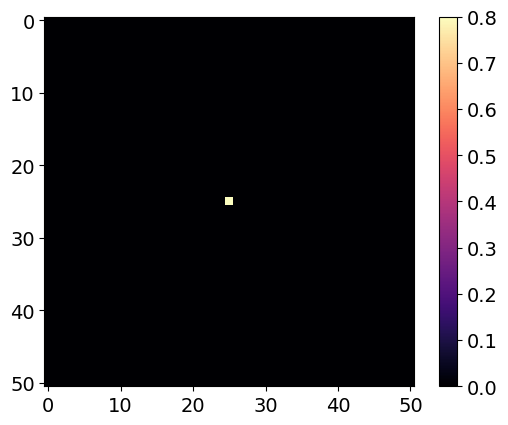

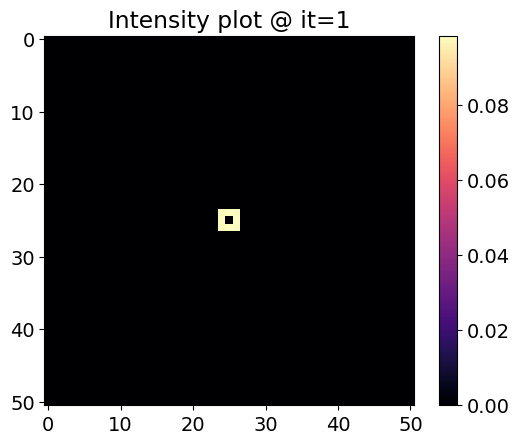

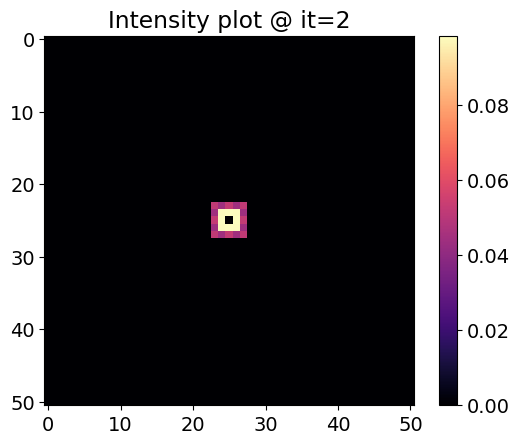

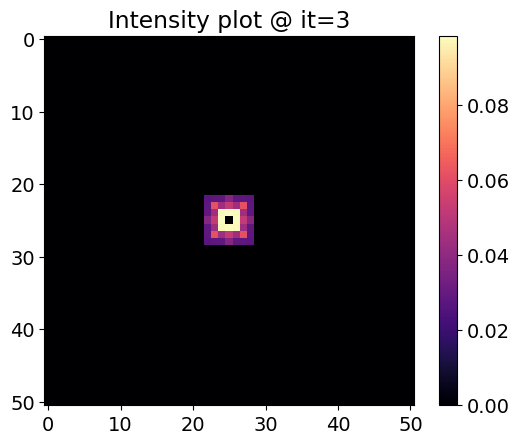

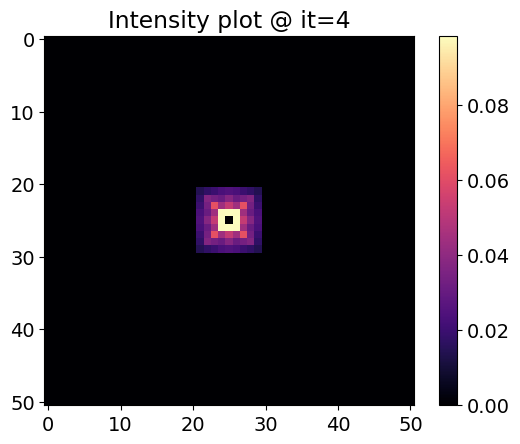

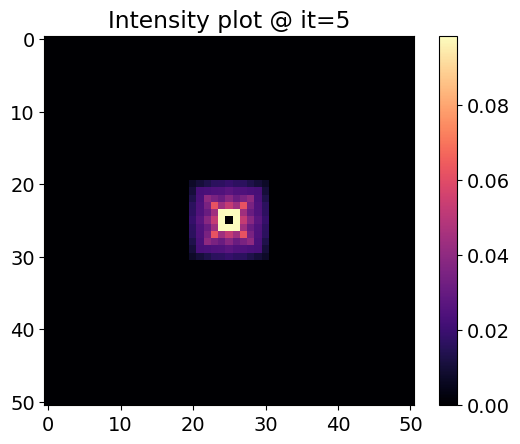

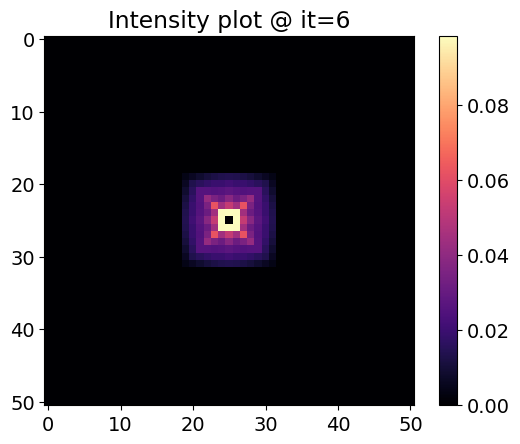

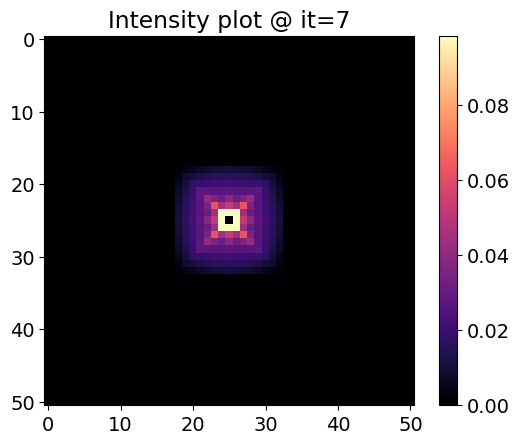

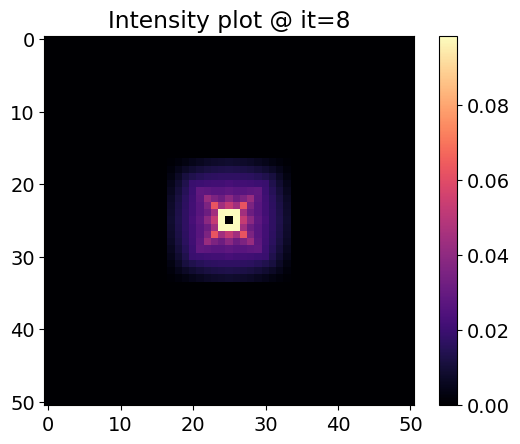

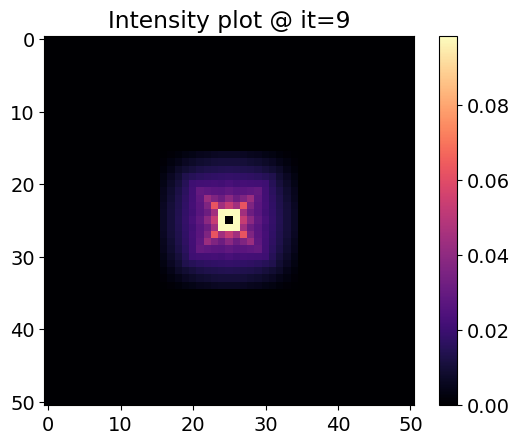

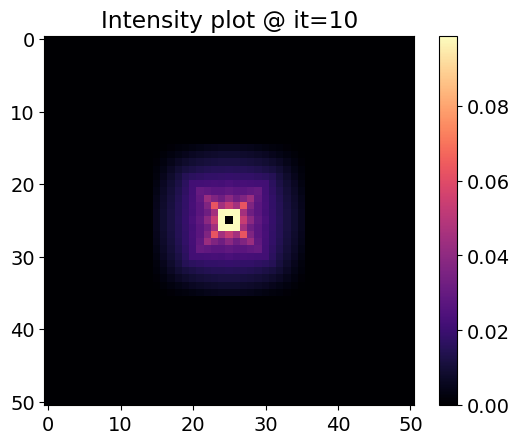

In [140]:
NX = 51
NY = 51

sources = [
    # (0+1, NY-1-1)
    # (0, NY-1)
    ((NX//2, NY//2), [0.1] * 8)
    # (NX-1, 0)
]

x = simulate(NX, NY, sources, redist_coeff=0.55, n_it=10, plotRealTime=True, plotLattViz=True, plot_period=1)

In [144]:
# !convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './frames/*.png' './frames/output.gif'
!convert -limit memory 2GiB -loop 0 -layers optimize -resize 1000 -delay 50 './lattviz_frames/*.png' './lattviz_frames/output.gif'

In [127]:
from PIL import Image
import os

def pngs_to_gif(folder_path, output_gif, duration=500):
    images = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith(".png"):
            img_path = os.path.join(folder_path, file)
            images.append(Image.open(img_path).convert("RGBA"))

    if images:
        images[0].save(
            output_gif,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )
        print(f"GIF saved as {output_gif}")
    else:
        print("No PNG files found in the folder.")

# Example usage
folder = "./lattviz_frames"
output = "lattviz.gif"
pngs_to_gif(folder, output, duration=1000)

GIF saved as lattviz.gif


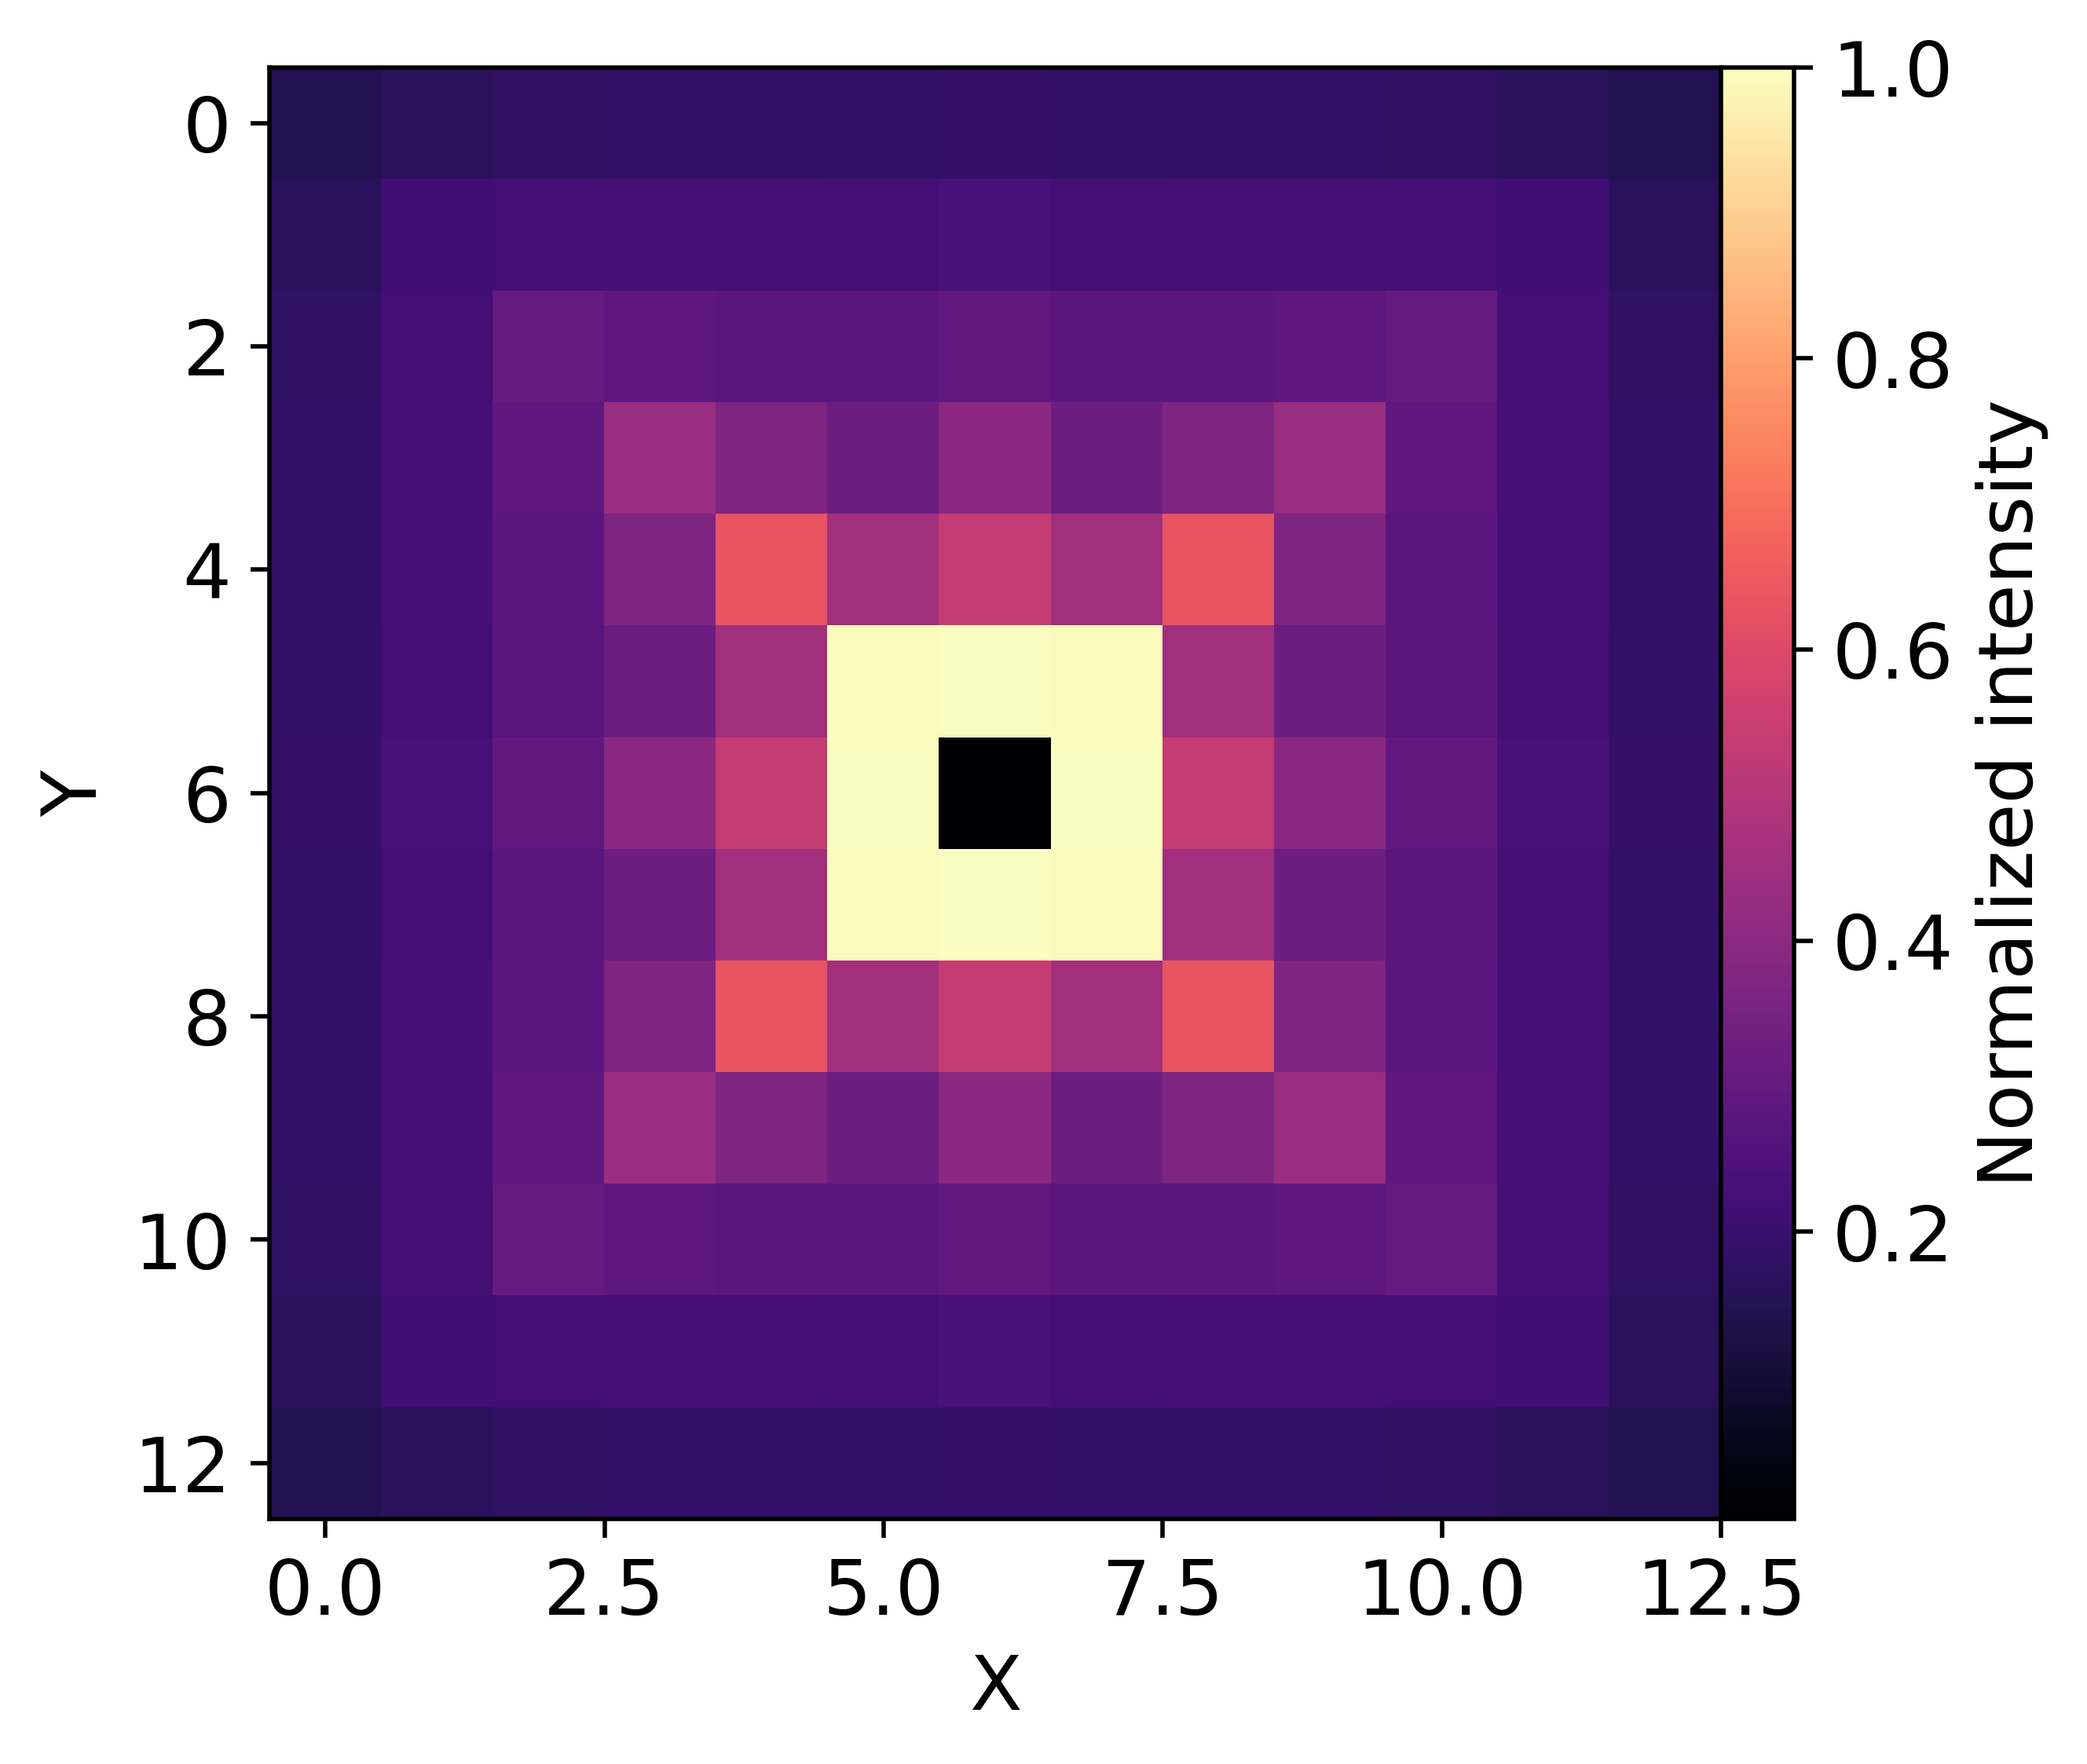

In [145]:
def plot_zoom():
    fig, ax = plt.subplots()
    
    # X = np.sum(x, axis=2) # full

    # X = np.sum(x[:NY//2+1, NX//2:], axis=2) # top-right corner
    # X = np.sum(x[3*N//4:, :N//4], axis=2) # bottom-left corner
    
    # X = np.sum(x[1*NY//4+1:3*NY//4, 1*NX//4+1:3*NX//4], axis=2) # center half
    X = np.sum(x[3*NY//8:5*NY//8+1, 3*NX//8:5*NX//8+1], axis=2) # center fourth
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-left corner
    # X = np.sum(x[3*NY//8:4*NY//8, 4*NX//8:5*NX//8], axis=2) # center top-right corner
    
    # print(X)
    
    cax = plt.imshow(X/np.max(X), cmap="magma")
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    divider = make_axes_locatable(ax)
    cbaxes = divider.append_axes("right", size="5%", pad=0.0)  # Adjust pad to 0 for no gap
    cb = fig.colorbar(cax, cax=cbaxes, label="Normalized intensity")
    
    ax.set_aspect(1)
    plt.gcf().set_dpi(500)
    
    plt.rcParams.update({'font.size': 14})
    
    plt.savefig("redistribution_plot.png", dpi=500)

plot_zoom()

(10, 10, 8)


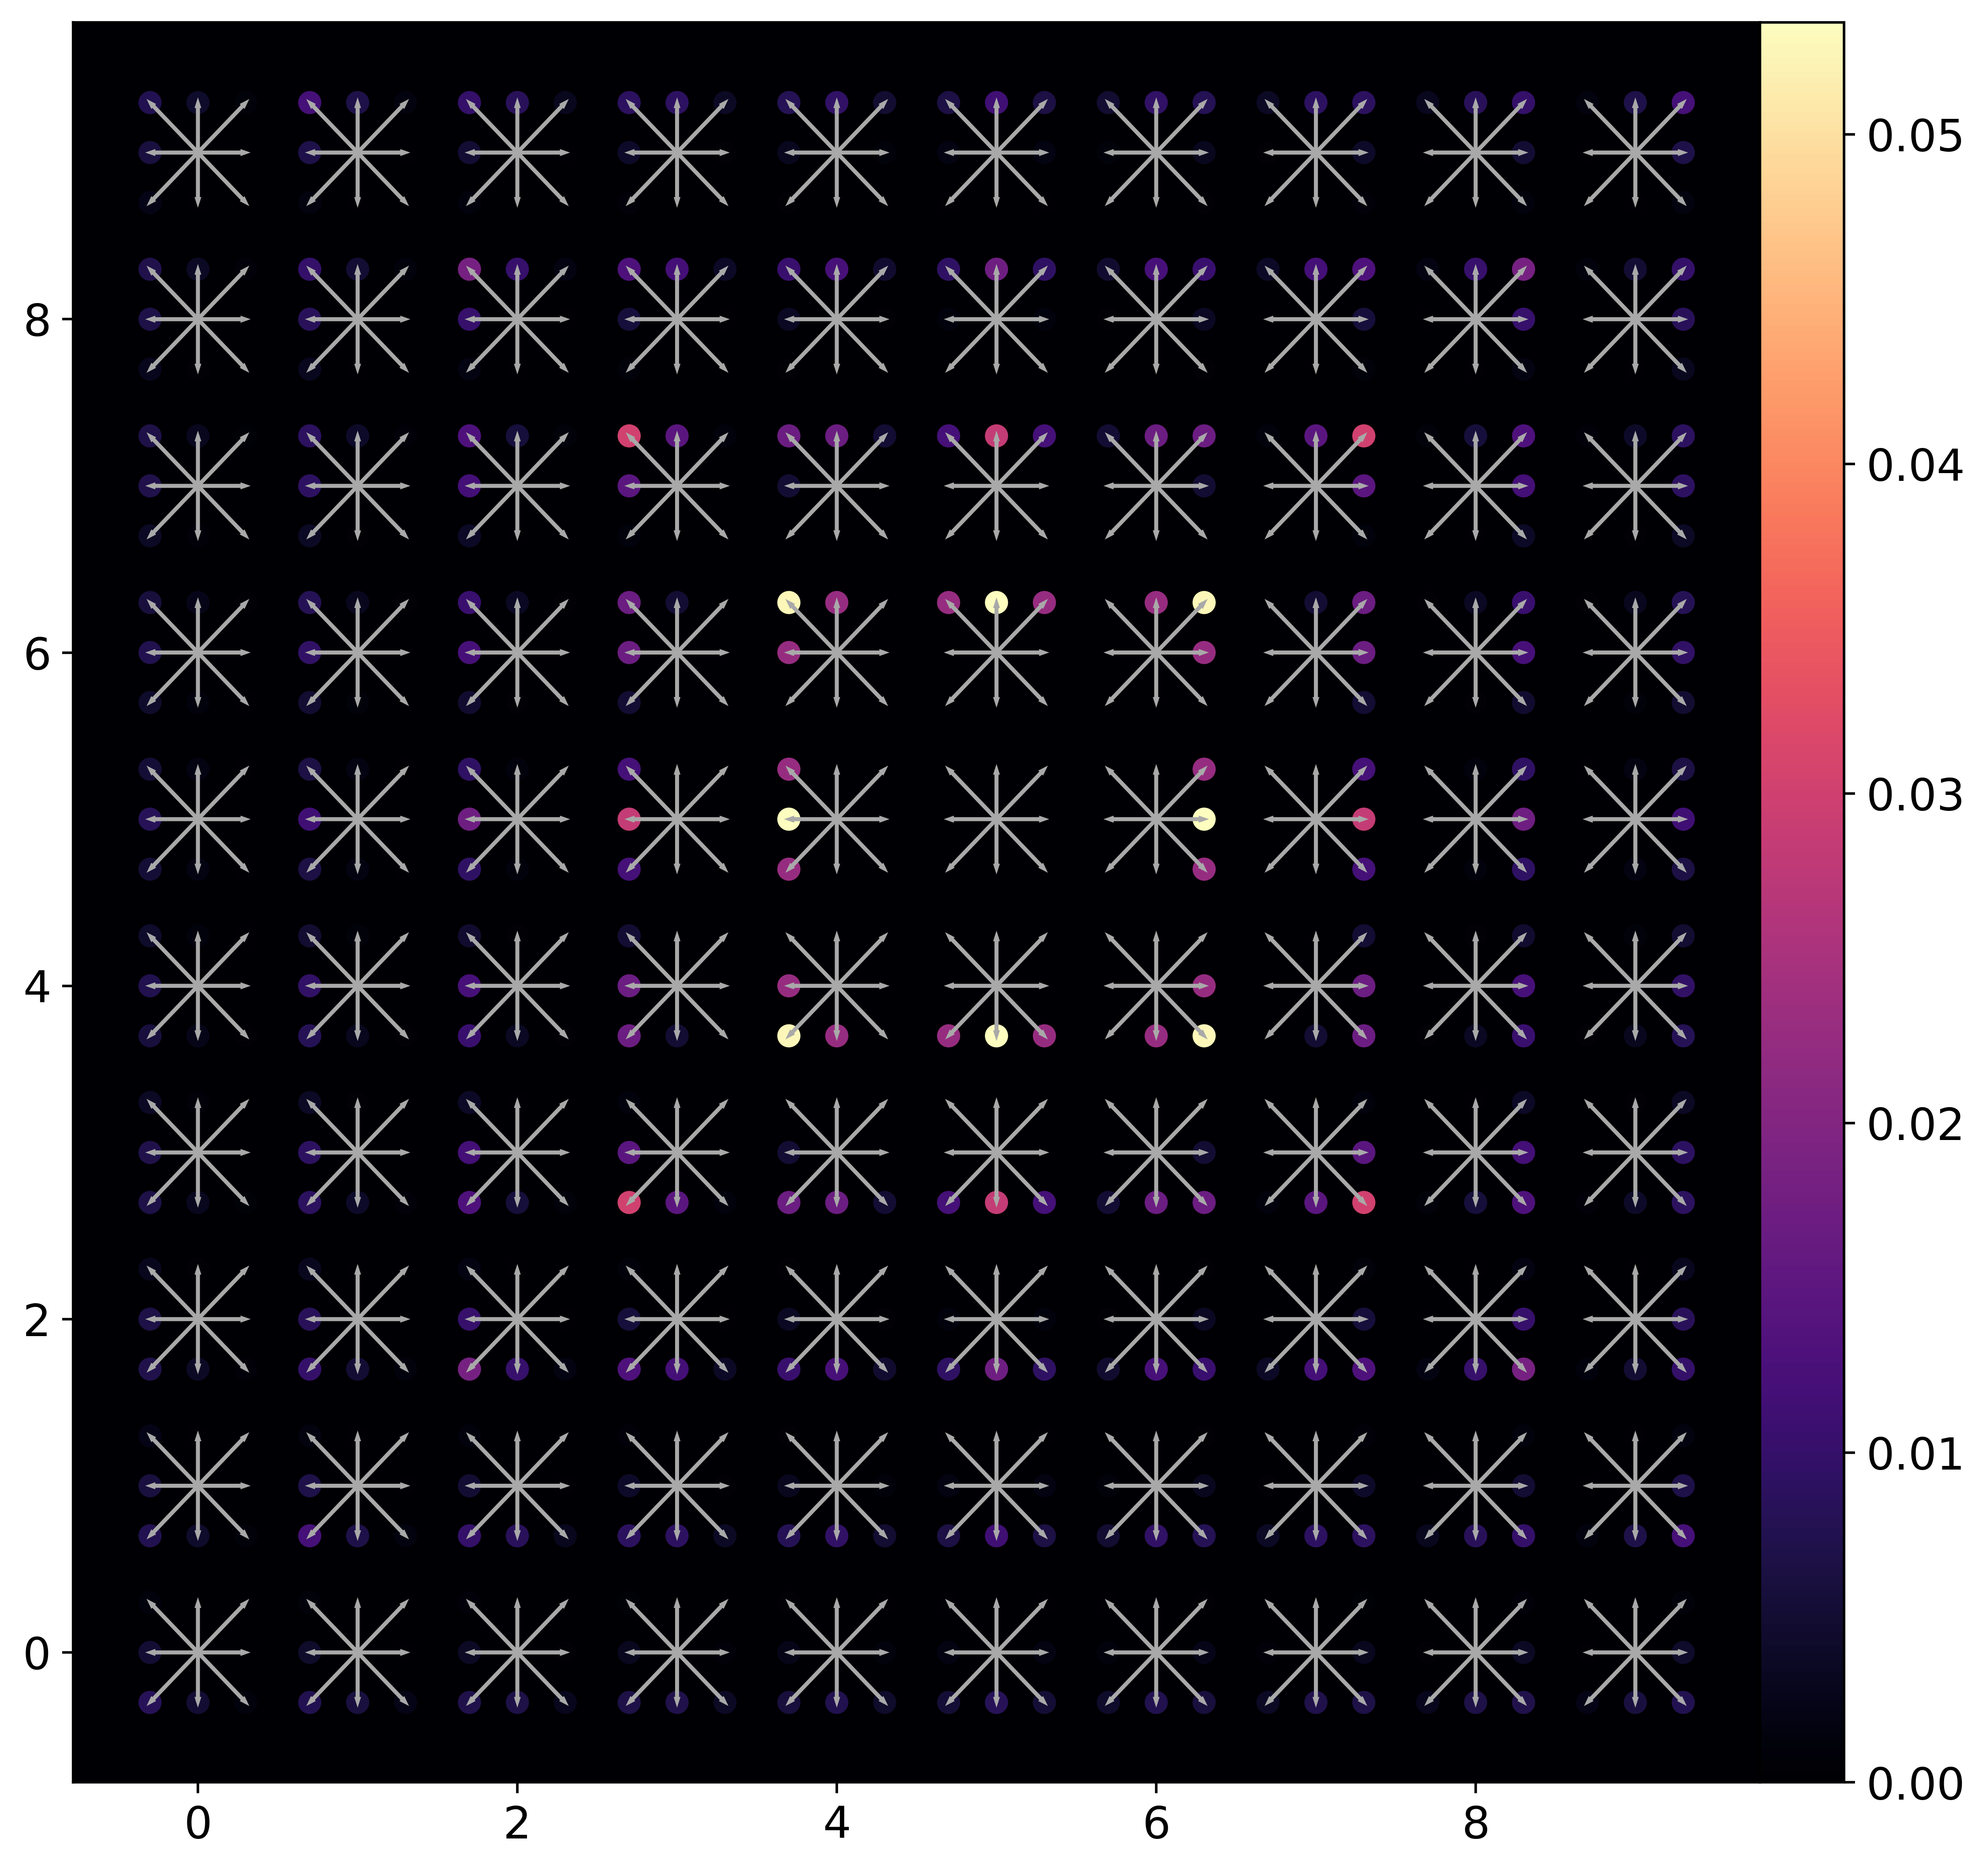

In [146]:
# lattice = x[3*NY//8+1:5*NY//8, 3*NX//8+1:5*NX//8]

Y_c = NY//2
X_c = NX//2
lattice = x[Y_c-5:Y_c+5, X_c-5:X_c+5]

print(lattice.shape)
draw_lattice_2d_local(lattice, cxs, cys)

In [147]:
np.save("redistribution_data.npy", x)
assert np.allclose(x, np.load("redistribution_data.npy"))

In [148]:
x = np.load("redistribution_data.npy")

[0.46230919]


/var/tmp/ipykernel_3233213/2016386159.py:11: RuntimeWarning: divide by zero encountered in power
  return k * np.power(x, -2)


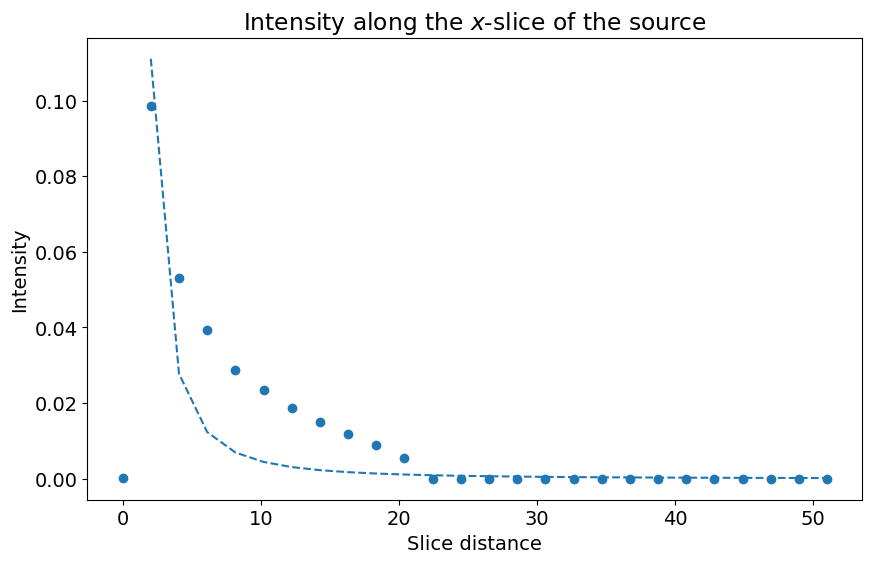

In [155]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot simulation results
intensity_slice = np.sum(x, axis=2)[sources[0][0][1], NX//2:NX]
coordinate_slice = np.linspace(0, NX, intensity_slice.size)

plt.scatter(coordinate_slice, intensity_slice)

# Perform fit
def inverse_square(x, k):
    return k * np.power(x, -2)

def inverse_exp(x, k, b):
    return k * np.exp(-b*x)

def gaussian(x, A, b, c):
    return A * np.exp(-(x-b)**2/(2*c))

def mwbm(x, a, b):
    return (2/np.pi)**0.5 * (x+b)**2/a**3 * np.exp(-(x-b)**2/(2*a**2))

i_start = 1
i_stop = len(intensity_slice)

fit_func = inverse_square

fit_params, _ = curve_fit(fit_func, coordinate_slice[i_start:i_stop], intensity_slice[i_start:i_stop])
print(fit_params)

fit_intensity_slice = fit_func(coordinate_slice, *fit_params)
plt.plot(coordinate_slice, fit_intensity_slice, "--")

plt.title("Intensity along the $x$-slice of the source")

ax.set_xlabel("Slice distance")
ax.set_ylabel("Intensity")

plt.savefig("redistribution_slice.png", dpi=500)
plt.show()

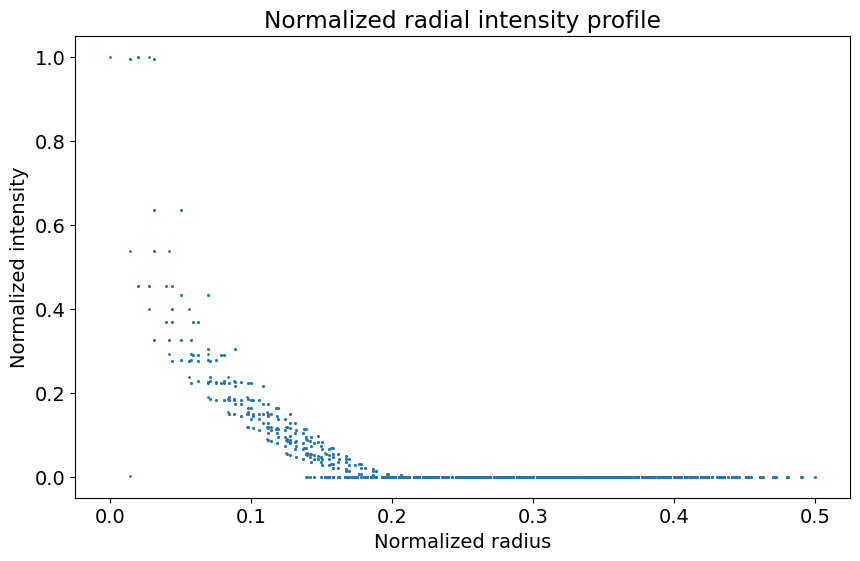

In [150]:
# manual 2D radial profile plot
slice_r = []
slice_I = []

hx = sources[0][0][0]
hy = sources[0][0][1]
hz = 0

N = np.sqrt(NX**2 + NY**2 + 1**2)

k = 0 # we select the slice z = 0
for i in range(NX):
    for j in range(NY):
        # j = i
        r = np.sqrt((i-hx)**2 + (hy-j-1)**2 + (k-hz)**2)
        slice_r.append(r/N)
        slice_I.append(np.sum(x[j, i]))
        
        # print(r, (x, y, z), intensity_slice[x, y].value)

slice_I /= np.max(slice_I)

fig, ax = plt.subplots(figsize=(10, 6))

plt.scatter(slice_r, slice_I, s=1)

plt.title("Normalized radial intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Normalized intensity")

plt.savefig("redistribution_radial_profile.png", dpi=1000)
plt.show()

In [151]:
slice_r_groups = {}

for r, I in zip(slice_r, slice_I):
    if r in slice_r_groups:
        slice_r_groups[r].append(I)
    else:
        slice_r_groups[r] = [I]

slice_r_values = []
slice_I_means = []
slice_I_stdevs = []
for r, I_list in slice_r_groups.items():
    slice_r_values.append(r)
    slice_I_means.append(np.mean(I_list))
    slice_I_stdevs.append(np.std(I_list))

slice_I_means = np.array(slice_I_means)
slice_I_stdevs = np.array(slice_I_stdevs)

print(np.shape(slice_r_values), np.shape(slice_I_means), np.shape(slice_I_stdevs))
print(np.std(slice_I), np.mean(slice_I_stdevs))

(314,) (314,) (314,)
0.09177278712275362 0.009729699892818168


In [152]:
# Simultaneously sort both the radii and intensities
z = zip(slice_r_values, slice_I_means)
zs = sorted(z)
u = zip(*zs)
slice_r_values, slice_I_means = map(list, u)
slice_r_values, slice_I_means = np.array(slice_r_values), np.array(slice_I_means)

[0.00021627]


/var/tmp/ipykernel_3233213/1165217930.py:11: RuntimeWarning: divide by zero encountered in power
  return k * np.power(x, -2)


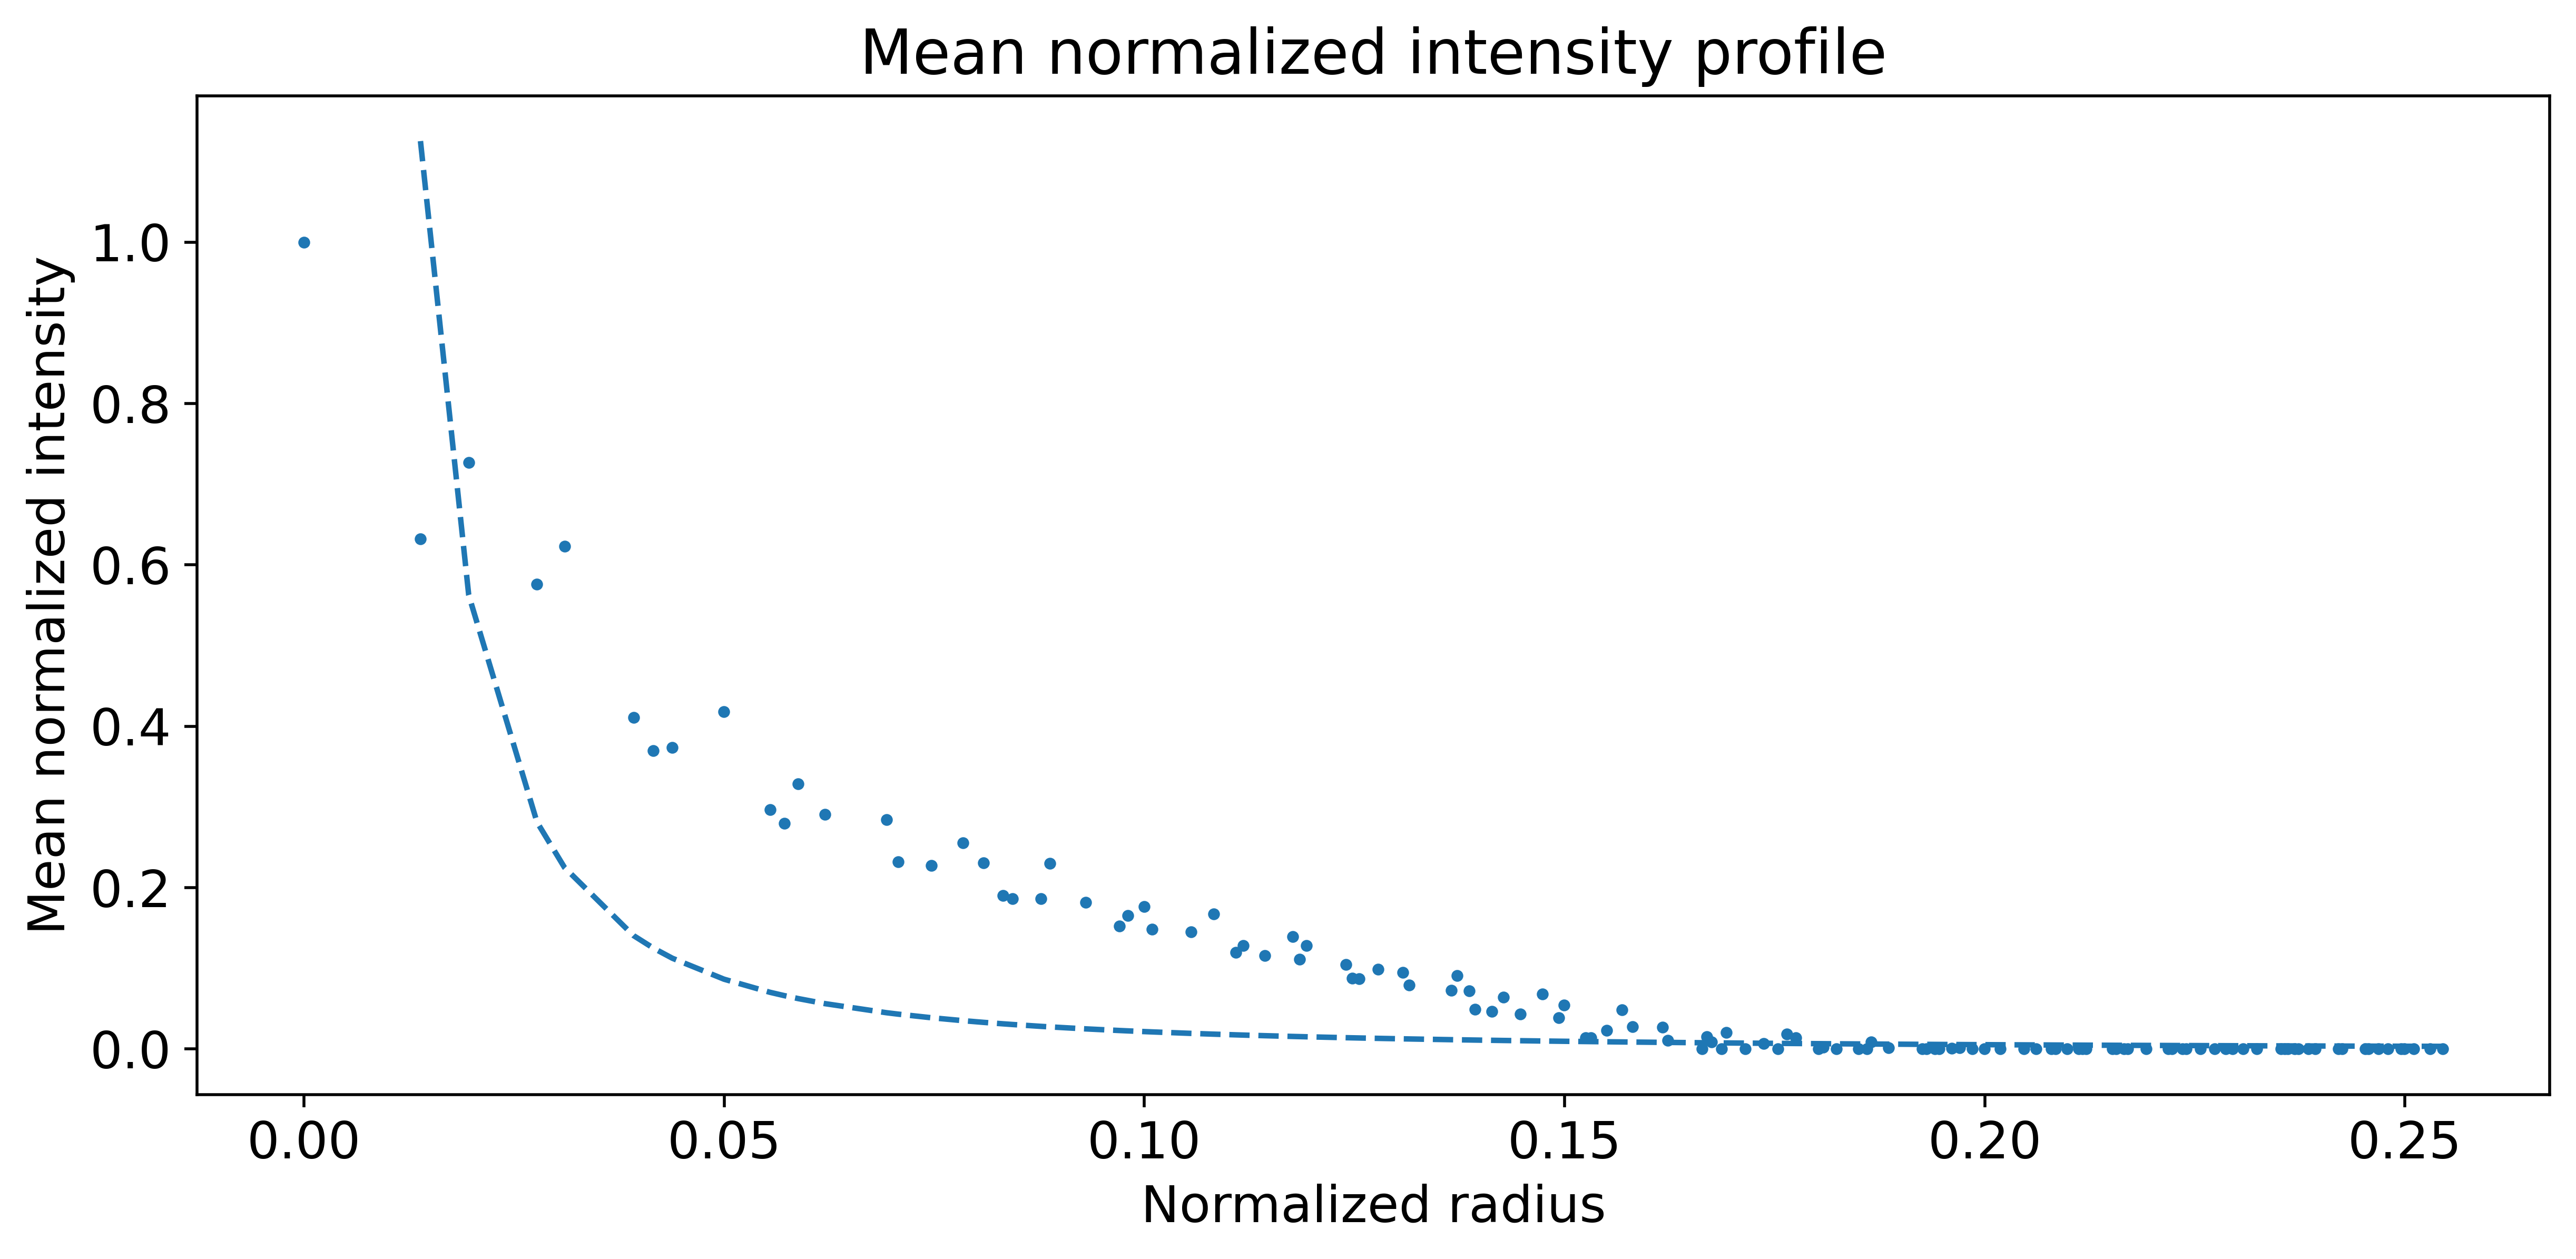

In [153]:
fig, ax = plt.subplots(figsize=(10,5))

xlim = int(len(slice_r_values) * 0.4)

plt.scatter(slice_r_values[:xlim], slice_I_means[:xlim], s=5)

# Perform fit
i_start = 1
i_stop = min(xlim, len(slice_I_means))

fit_func = inverse_square

fit_params, _ = curve_fit(fit_func, slice_r_values[i_start:i_stop], slice_I_means[i_start:i_stop])
print(fit_params)

fit_intensity_slice = fit_func(slice_r_values, *fit_params)
plt.plot(slice_r_values[:xlim], fit_intensity_slice[:xlim], "--")

plt.title("Mean normalized intensity profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Mean normalized intensity")

plt.gcf().set_dpi(500)
plt.tight_layout()

plt.savefig("redistribution_mean_radial_profile.png", dpi=1000)
plt.show()

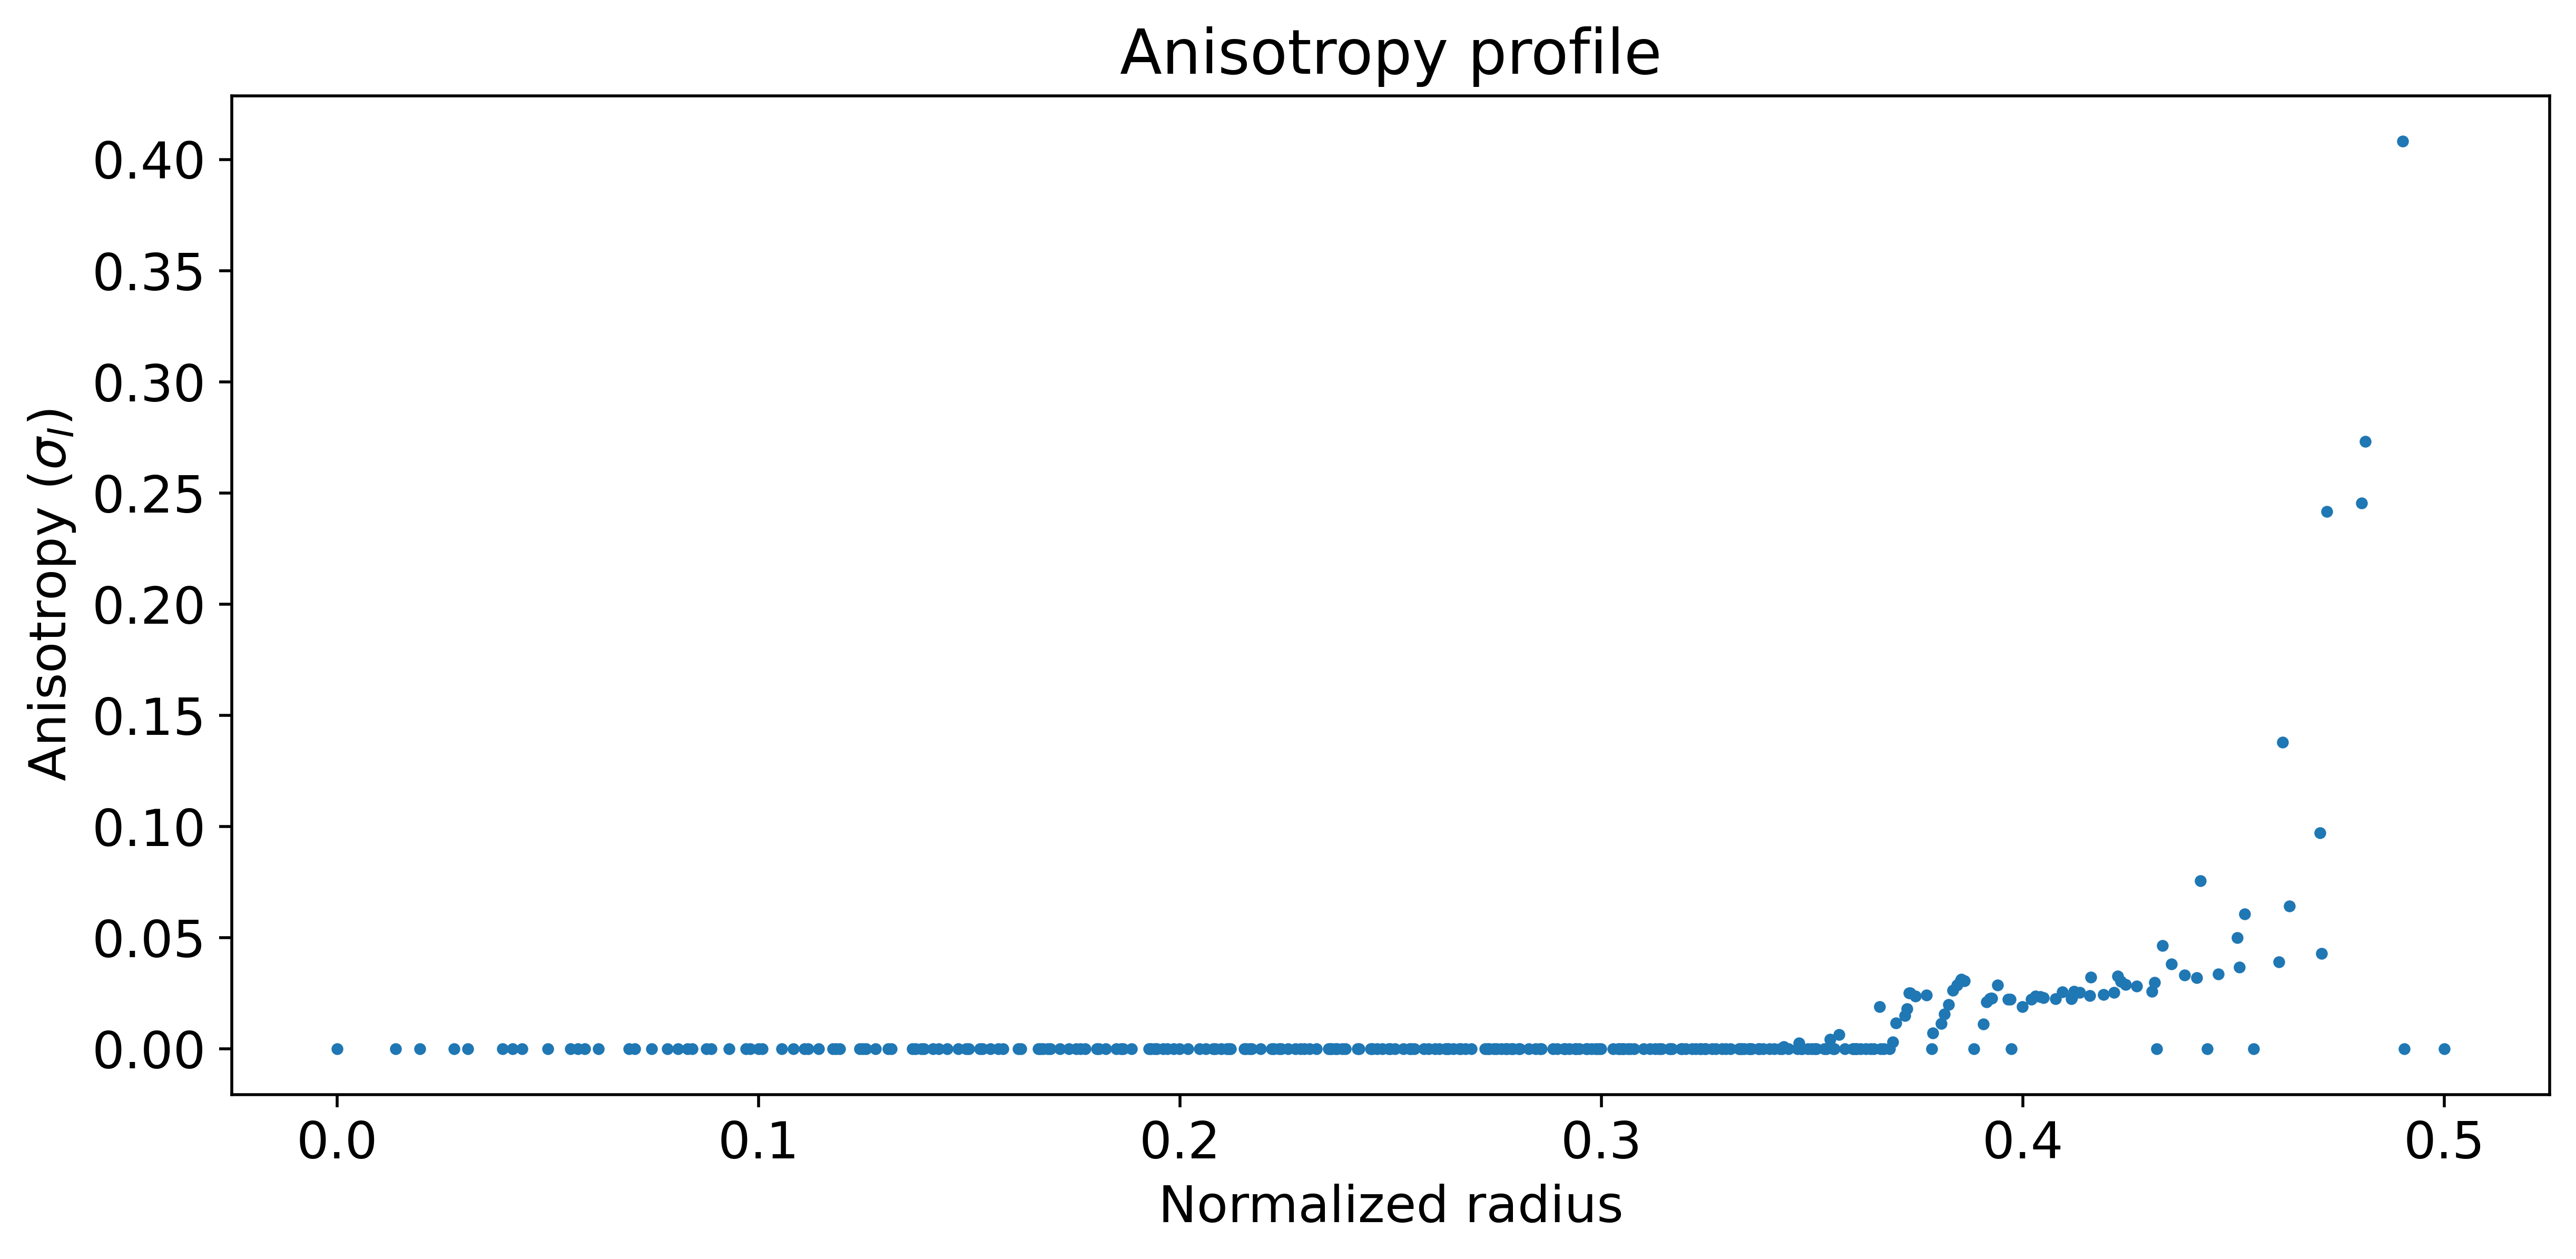

In [154]:
# @TODO - Test other measures of anisotropy (why isn't relative error working?)
fig, ax = plt.subplots(figsize=(10,5))

xlim = int(len(slice_r_values) * 1.0)

plt.scatter(slice_r_values[:xlim], slice_I_stdevs[:xlim], s=5)
# plt.scatter(slice_r_values, slice_I_stdevs/slice_I_means, s=1)

plt.title("Anisotropy profile")

ax.set_xlabel("Normalized radius")
ax.set_ylabel("Anisotropy ($\\sigma_I$)")

plt.gcf().set_dpi(500)
plt.tight_layout()

plt.savefig("redistribution_anisotropy.png", dpi=1000)
plt.show()